# 합성곱 신경망(CNN : Convolutional Nerual Network) (Part 2/3)

+ 기존의 Fully-Connected 모델은 1차원의 데이터 말고 2차원 이상의 데이터를 사용하게 된다면, 해당 입력 데이터를 Flatten시켜 한 줄의 데이터로 만들어야 한다.
+ 이 과정에서 데이터의 손상이 발생하게 된다.
+ 이미지의 경우에는 상하좌우 이웃 픽셀의 정보가 손실된다.
+ 위 문제를 해결하기 위해 고안한 해결책이 바로 CNN이다.

**CNN 장점**
> + 단순 Fully-connected 보다 학습시킬 weight가 적다.
> + 학습과 연산에 속도가 빠르며, 효율적이다.
> + 이미지나 영상데이터를 처리할 때 사용한다.
---

**CNN의 접근**
![image](https://user-images.githubusercontent.com/28241676/152975808-7954439f-1887-4f3f-a624-26e36ba80398.png)

---
**이미지 표현 => Matrix**
![image](https://user-images.githubusercontent.com/28241676/152975987-95af8253-db60-4afd-a6fb-82aa04990a87.png)

*해당 실습에서 사용된 데이터와 코드(.ipynb)는 아래 링크에서 확인할 수 있습니다.*
+ 데이터 : https://github.com/JoSangYeon/Machine_Learning_Project/tree/master/Data
+ 코 드  : https://github.com/JoSangYeon/Machine_Learning_Project/blob/master/04.%20CNN.ipynb

## 패키지 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary as summary_


from tqdm import tqdm, notebook

## 데이터 살펴보기
### Fashion MNIST Dataset

In [2]:
# label_tags = ["티셔츠/탑", "트루저", "풀오버", "드레스", "코트", "샌들", "셔츠", "스니커", "가방", "앵클부츠"]
label_tags = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

train_dataset = pd.read_csv("Data/fashion-mnist_train.csv")
test_dataset = pd.read_csv("Data/fashion-mnist_test.csv")

# Split to Image & Label
train_images = (train_dataset.iloc[:, 1:].values).astype("float32")
train_labels = train_dataset["label"].values
test_images = (test_dataset.iloc[:, 1:].values).astype("float32")
test_labels = test_dataset["label"].values

In [3]:
# Split into Train, Valid Dataset
from sklearn.model_selection import train_test_split
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, 
                                                                          train_labels, 
                                                                          stratify = train_labels, 
                                                                          random_state = 42, 
                                                                          test_size = 0.2)

In [4]:
# Reshape image's size to check for ours
# (size, 784) => (size, 28, 28)
train_images = train_images.reshape(train_images.shape[0], 28, 28)
valid_images = valid_images.reshape(valid_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

In [5]:
# Check Train, Valid, Test Image's Shape
print("The Shape of Train Images: ", train_images.shape)
print("The Shape of Valid Images: ", valid_images.shape)
print("The Shape of Test Images: ", test_images.shape)

# Check Train, Valid Label's Shape
print("The Shape of Train Labels: ", train_labels.shape)
print("The Shape of Valid Labels: ", valid_labels.shape)
print("The Shape of Valid Labels: ", test_labels.shape)

The Shape of Train Images:  (48000, 28, 28)
The Shape of Valid Images:  (12000, 28, 28)
The Shape of Test Images:  (10000, 28, 28)
The Shape of Train Labels:  (48000,)
The Shape of Valid Labels:  (12000,)
The Shape of Valid Labels:  (10000,)


Label : Pullover


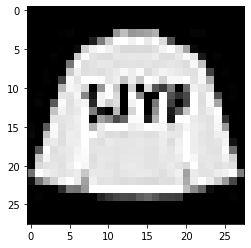

In [6]:
# 데이터 시각화
img = train_images[20]
label = train_labels[20]

print("Label :",label_tags[label])
plt.imshow(img, cmap='gray'); plt.show()

## Dataset 정의

In [7]:
class MyDataset(Dataset):
    def __init__(self, feature_data, label_data, num_classes = 10):
        self.x_data = feature_data
        self.y_data = label_data
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        # image
        img = self.x_data[idx] / 255.       # 명암값 정규화
        img = torch.FloatTensor(img)        # Tensor로 변환
        img = img.view(1, 28, 28)           # (channel, width, height)

        # label
        label = torch.tensor(self.y_data[idx])
        label = F.one_hot(label, num_classes = self.num_classes)        # one-hot 인코딩
        label = label.float()

        return img, label

In [8]:
label_tags = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle Boot']

train_dataset = MyDataset(train_images, train_labels)
valid_dataset = MyDataset(valid_images, valid_labels)
test_dataset = MyDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 32)
test_loader = DataLoader(test_dataset, batch_size = 32)

print(train_loader)
print(valid_loader)
print(test_loader)

## 훈련 & 검증 함수 정의

In [17]:
loss_fn = nn.CrossEntropyLoss()

def calc_acc(X, Y):
    x_val, x_idx = torch.max(X, dim=1)
    y_val, y_idx = torch.max(Y, dim=1)
    return (x_idx == y_idx).sum().item()

def train(EPOCHS, model, train_loader, opt):
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    for epoch in range(1, EPOCHS+1):
        model.train()
        train_acc = 0
        print("<<< EPOCH {} >>>".format(epoch))
        for batch_idx, (img,label) in enumerate(notebook.tqdm(train_loader)):
            img, label = img.to(DEVICE), label.to(DEVICE)
            
            output = model(img)                 # 순전파
            loss = loss_fn(output, label)       # 오차 계산
            
            opt.zero_grad()                     # opt내부 값 초기화
            loss.backward()                     # 오차 역전파
            opt.step()                          # 가중치 갱신
            
            train_acc += calc_acc(output, label)
            if batch_idx % 100 == 0 and batch_idx != 0:
                print("Training : [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Acc : {:.3f}".format(
                    batch_idx * len(img), 
                    len(train_loader.dataset), 
                    100. * batch_idx / len(train_loader), 
                    loss.item(),
                    train_acc / len(train_loader.dataset)))
        t_loss, t_acc = evaluate(model, valid_loader)
        print("[{}] valid Loss : {:.4f}\t accuracy: {:.2f}%\n\n".format(epoch, t_loss, t_acc*100.))

        train_loss_history.append(loss.item())
        train_acc_history.append(train_acc / len(train_loader.dataset))

        valid_loss_history.append(t_loss.item())
        valid_acc_history.append(t_acc)

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history
                
def evaluate(model, valid_loader):
    model.eval()
    t_loss = 0
    correct = 0
    
    with torch.no_grad():
        for img, label in notebook.tqdm(valid_loader):
            img, label = img.to(DEVICE), label.to(DEVICE)
            
            output = model(img)
            t_loss += loss_fn(output, label)
            
            correct += calc_acc(output, label)

    t_loss /= len(valid_loader)
    t_acc = correct / len(valid_loader.dataset)
    return t_loss, t_acc

def predict(model, lower=0, upper=10):
    model.eval()
    for idx in range(lower, upper):
        img, _ = test_dataset.__getitem__(idx)

        output = model(img.view(1, 1, 28, 28))

        o_val, o_idx = torch.max(output, dim=1)

        print("Label :", label_tags[o_idx.item()])
        plt.imshow(img.view(28, 28), cmap='gray')
        plt.show()
        print()

## 모델 정의

## Linear Net

In [18]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.act_fn = nn.LeakyReLU()

    def forward(self, x):
        x = x.view(-1, 1*28*28)

        x = self.fc1(x)
        x = self.act_fn(x)

        x = self.fc2(x)
        x = self.act_fn(x)

        x = self.fc3(x)
        return x

## CNN

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(8 , 16, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.flatten = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(64, 24)
        self.fc2 = nn.Linear(24, 10)

        self.act_fn = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)           # (batch, 1, 28, 28) -> (batch, 8, 28, 28)
        x = self.pooling(x)         # (batch, 8, 28, 28) -> (batch, 8, 14, 14)
        x = self.act_fn(x)

        x = self.conv2(x)           # (batch, 8, 14, 14) -> (batch, 16, 14, 14)
        x = self.pooling(x)         # (batch, 16, 14, 14) -> (batch, 16, 7, 7)
        x = self.act_fn(x)

        x = self.conv3(x)           # (batch, 16, 7, 7) -> (batch, 32, 7, 7)
        x = self.pooling(x)         # (batch, 32, 7, 7) -> (batch, 32, 3, 3)
        x = self.act_fn(x)
        
        x = self.conv4(x)           # (batch, 32, 3, 3) -> (batch, 64, 3, 3)
        x = self.pooling(x)         # (batch, 64, 3, 3) -> (batch, 64, 1, 1)
        x = self.act_fn(x)        

        x = self.flatten(x)         # # (batch, 64, 3, 3) -> (batch, 64, 1, 1)
        x = x.view(-1, 64*1*1)
        
        x = self.fc1(x)
        x = self.act_fn(x)

        x = self.fc2(x)
        return x

## 훈련 및 검증

### Linear Net

In [30]:
USE_CUDA = torch.cuda.is_available()
DEVICE = "cuda" if USE_CUDA else "cpu"

model = LinearNet().to(DEVICE)
opt = optim.Adam(model.parameters())

print("Device :", DEVICE)
summary_(model,(1,28,28), device=DEVICE)

Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
         LeakyReLU-2                  [-1, 256]               0
            Linear-3                   [-1, 64]          16,448
         LeakyReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 10]             650
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.83
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [31]:
# 학습 시작 #
t_loss_his, t_acc_his, v_loss_his, v_acc_his = train(EPOCHS = 10, model = model, train_loader = train_loader, opt = opt)

<<< EPOCH 1 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.735302	 Acc : 0.041
Training : [6400/48000 (13%)]	Loss: 0.429874	 Acc : 0.091
Training : [9600/48000 (20%)]	Loss: 0.437708	 Acc : 0.143
Training : [12800/48000 (27%)]	Loss: 0.357811	 Acc : 0.196
Training : [16000/48000 (33%)]	Loss: 0.395073	 Acc : 0.251
Training : [19200/48000 (40%)]	Loss: 0.548772	 Acc : 0.305
Training : [22400/48000 (47%)]	Loss: 0.582758	 Acc : 0.360
Training : [25600/48000 (53%)]	Loss: 0.489112	 Acc : 0.416
Training : [28800/48000 (60%)]	Loss: 0.352894	 Acc : 0.471
Training : [32000/48000 (67%)]	Loss: 0.434810	 Acc : 0.526
Training : [35200/48000 (73%)]	Loss: 0.329541	 Acc : 0.583
Training : [38400/48000 (80%)]	Loss: 0.274741	 Acc : 0.639
Training : [41600/48000 (87%)]	Loss: 0.259201	 Acc : 0.695
Training : [44800/48000 (93%)]	Loss: 0.350932	 Acc : 0.752


  0%|          | 0/375 [00:00<?, ?it/s]

[1] valid Loss : 0.3948	 accuracy: 84.87%


<<< EPOCH 2 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.448148	 Acc : 0.057
Training : [6400/48000 (13%)]	Loss: 0.456143	 Acc : 0.114
Training : [9600/48000 (20%)]	Loss: 0.389178	 Acc : 0.171
Training : [12800/48000 (27%)]	Loss: 0.145121	 Acc : 0.228
Training : [16000/48000 (33%)]	Loss: 0.290434	 Acc : 0.285
Training : [19200/48000 (40%)]	Loss: 0.479880	 Acc : 0.343
Training : [22400/48000 (47%)]	Loss: 0.483696	 Acc : 0.400
Training : [25600/48000 (53%)]	Loss: 0.155877	 Acc : 0.458
Training : [28800/48000 (60%)]	Loss: 0.268751	 Acc : 0.514
Training : [32000/48000 (67%)]	Loss: 0.311034	 Acc : 0.572
Training : [35200/48000 (73%)]	Loss: 0.415847	 Acc : 0.630
Training : [38400/48000 (80%)]	Loss: 0.326008	 Acc : 0.687
Training : [41600/48000 (87%)]	Loss: 0.312699	 Acc : 0.745
Training : [44800/48000 (93%)]	Loss: 0.507022	 Acc : 0.803


  0%|          | 0/375 [00:00<?, ?it/s]

[2] valid Loss : 0.3696	 accuracy: 86.38%


<<< EPOCH 3 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.318991	 Acc : 0.059
Training : [6400/48000 (13%)]	Loss: 0.279758	 Acc : 0.117
Training : [9600/48000 (20%)]	Loss: 0.096477	 Acc : 0.175
Training : [12800/48000 (27%)]	Loss: 0.301764	 Acc : 0.234
Training : [16000/48000 (33%)]	Loss: 0.470610	 Acc : 0.291
Training : [19200/48000 (40%)]	Loss: 0.197499	 Acc : 0.350
Training : [22400/48000 (47%)]	Loss: 0.372421	 Acc : 0.407
Training : [25600/48000 (53%)]	Loss: 0.525115	 Acc : 0.466
Training : [28800/48000 (60%)]	Loss: 0.429163	 Acc : 0.524
Training : [32000/48000 (67%)]	Loss: 0.279217	 Acc : 0.582
Training : [35200/48000 (73%)]	Loss: 0.236866	 Acc : 0.641
Training : [38400/48000 (80%)]	Loss: 0.302564	 Acc : 0.699
Training : [41600/48000 (87%)]	Loss: 0.524992	 Acc : 0.758
Training : [44800/48000 (93%)]	Loss: 0.443039	 Acc : 0.816


  0%|          | 0/375 [00:00<?, ?it/s]

[3] valid Loss : 0.3667	 accuracy: 86.43%


<<< EPOCH 4 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.274190	 Acc : 0.059
Training : [6400/48000 (13%)]	Loss: 0.265132	 Acc : 0.118
Training : [9600/48000 (20%)]	Loss: 0.164344	 Acc : 0.177
Training : [12800/48000 (27%)]	Loss: 0.334045	 Acc : 0.236
Training : [16000/48000 (33%)]	Loss: 0.663273	 Acc : 0.295
Training : [19200/48000 (40%)]	Loss: 0.216514	 Acc : 0.354
Training : [22400/48000 (47%)]	Loss: 0.166677	 Acc : 0.413
Training : [25600/48000 (53%)]	Loss: 0.395569	 Acc : 0.472
Training : [28800/48000 (60%)]	Loss: 0.196698	 Acc : 0.531
Training : [32000/48000 (67%)]	Loss: 0.518613	 Acc : 0.590
Training : [35200/48000 (73%)]	Loss: 0.316425	 Acc : 0.649
Training : [38400/48000 (80%)]	Loss: 0.296644	 Acc : 0.708
Training : [41600/48000 (87%)]	Loss: 0.238176	 Acc : 0.767
Training : [44800/48000 (93%)]	Loss: 0.252924	 Acc : 0.826


  0%|          | 0/375 [00:00<?, ?it/s]

[4] valid Loss : 0.3495	 accuracy: 87.14%


<<< EPOCH 5 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.166381	 Acc : 0.060
Training : [6400/48000 (13%)]	Loss: 0.305189	 Acc : 0.119
Training : [9600/48000 (20%)]	Loss: 0.346858	 Acc : 0.178
Training : [12800/48000 (27%)]	Loss: 0.270480	 Acc : 0.238
Training : [16000/48000 (33%)]	Loss: 0.141643	 Acc : 0.296
Training : [19200/48000 (40%)]	Loss: 0.141821	 Acc : 0.356
Training : [22400/48000 (47%)]	Loss: 0.336187	 Acc : 0.415
Training : [25600/48000 (53%)]	Loss: 0.308360	 Acc : 0.475
Training : [28800/48000 (60%)]	Loss: 0.199161	 Acc : 0.534
Training : [32000/48000 (67%)]	Loss: 0.504691	 Acc : 0.593
Training : [35200/48000 (73%)]	Loss: 0.413327	 Acc : 0.653
Training : [38400/48000 (80%)]	Loss: 0.128112	 Acc : 0.712
Training : [41600/48000 (87%)]	Loss: 0.185107	 Acc : 0.772
Training : [44800/48000 (93%)]	Loss: 0.360918	 Acc : 0.830


  0%|          | 0/375 [00:00<?, ?it/s]

[5] valid Loss : 0.3450	 accuracy: 87.33%


<<< EPOCH 6 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.134799	 Acc : 0.060
Training : [6400/48000 (13%)]	Loss: 0.288316	 Acc : 0.120
Training : [9600/48000 (20%)]	Loss: 0.118618	 Acc : 0.180
Training : [12800/48000 (27%)]	Loss: 0.153470	 Acc : 0.240
Training : [16000/48000 (33%)]	Loss: 0.301417	 Acc : 0.299
Training : [19200/48000 (40%)]	Loss: 0.485130	 Acc : 0.358
Training : [22400/48000 (47%)]	Loss: 0.326108	 Acc : 0.418
Training : [25600/48000 (53%)]	Loss: 0.546504	 Acc : 0.477
Training : [28800/48000 (60%)]	Loss: 0.260103	 Acc : 0.536
Training : [32000/48000 (67%)]	Loss: 0.196125	 Acc : 0.596
Training : [35200/48000 (73%)]	Loss: 0.224432	 Acc : 0.655
Training : [38400/48000 (80%)]	Loss: 0.245428	 Acc : 0.715
Training : [41600/48000 (87%)]	Loss: 0.330523	 Acc : 0.775
Training : [44800/48000 (93%)]	Loss: 0.087961	 Acc : 0.835


  0%|          | 0/375 [00:00<?, ?it/s]

[6] valid Loss : 0.3241	 accuracy: 88.03%


<<< EPOCH 7 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.149255	 Acc : 0.060
Training : [6400/48000 (13%)]	Loss: 0.304750	 Acc : 0.120
Training : [9600/48000 (20%)]	Loss: 0.069160	 Acc : 0.180
Training : [12800/48000 (27%)]	Loss: 0.432408	 Acc : 0.239
Training : [16000/48000 (33%)]	Loss: 0.301639	 Acc : 0.299
Training : [19200/48000 (40%)]	Loss: 0.243132	 Acc : 0.359
Training : [22400/48000 (47%)]	Loss: 0.467878	 Acc : 0.419
Training : [25600/48000 (53%)]	Loss: 0.277644	 Acc : 0.480
Training : [28800/48000 (60%)]	Loss: 0.281952	 Acc : 0.540
Training : [32000/48000 (67%)]	Loss: 0.128633	 Acc : 0.601
Training : [35200/48000 (73%)]	Loss: 0.389777	 Acc : 0.660
Training : [38400/48000 (80%)]	Loss: 0.161849	 Acc : 0.720
Training : [41600/48000 (87%)]	Loss: 0.234918	 Acc : 0.780
Training : [44800/48000 (93%)]	Loss: 0.221204	 Acc : 0.840


  0%|          | 0/375 [00:00<?, ?it/s]

[7] valid Loss : 0.3214	 accuracy: 88.08%


<<< EPOCH 8 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.458626	 Acc : 0.061
Training : [6400/48000 (13%)]	Loss: 0.154441	 Acc : 0.121
Training : [9600/48000 (20%)]	Loss: 0.214524	 Acc : 0.181
Training : [12800/48000 (27%)]	Loss: 0.256739	 Acc : 0.241
Training : [16000/48000 (33%)]	Loss: 0.231911	 Acc : 0.301
Training : [19200/48000 (40%)]	Loss: 0.203256	 Acc : 0.361
Training : [22400/48000 (47%)]	Loss: 0.114346	 Acc : 0.422
Training : [25600/48000 (53%)]	Loss: 0.227190	 Acc : 0.482
Training : [28800/48000 (60%)]	Loss: 0.226464	 Acc : 0.543
Training : [32000/48000 (67%)]	Loss: 0.177185	 Acc : 0.603
Training : [35200/48000 (73%)]	Loss: 0.372691	 Acc : 0.663
Training : [38400/48000 (80%)]	Loss: 0.148210	 Acc : 0.724
Training : [41600/48000 (87%)]	Loss: 0.191321	 Acc : 0.784
Training : [44800/48000 (93%)]	Loss: 0.296551	 Acc : 0.844


  0%|          | 0/375 [00:00<?, ?it/s]

[8] valid Loss : 0.3104	 accuracy: 88.66%


<<< EPOCH 9 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.254257	 Acc : 0.061
Training : [6400/48000 (13%)]	Loss: 0.322637	 Acc : 0.122
Training : [9600/48000 (20%)]	Loss: 0.137620	 Acc : 0.182
Training : [12800/48000 (27%)]	Loss: 0.300177	 Acc : 0.242
Training : [16000/48000 (33%)]	Loss: 0.334867	 Acc : 0.303
Training : [19200/48000 (40%)]	Loss: 0.318614	 Acc : 0.363
Training : [22400/48000 (47%)]	Loss: 0.231747	 Acc : 0.423
Training : [25600/48000 (53%)]	Loss: 0.415765	 Acc : 0.484
Training : [28800/48000 (60%)]	Loss: 0.172975	 Acc : 0.544
Training : [32000/48000 (67%)]	Loss: 0.145282	 Acc : 0.604
Training : [35200/48000 (73%)]	Loss: 0.167290	 Acc : 0.664
Training : [38400/48000 (80%)]	Loss: 0.311487	 Acc : 0.725
Training : [41600/48000 (87%)]	Loss: 0.192379	 Acc : 0.786
Training : [44800/48000 (93%)]	Loss: 0.110205	 Acc : 0.847


  0%|          | 0/375 [00:00<?, ?it/s]

[9] valid Loss : 0.3531	 accuracy: 87.69%


<<< EPOCH 10 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.036901	 Acc : 0.061
Training : [6400/48000 (13%)]	Loss: 0.119846	 Acc : 0.122
Training : [9600/48000 (20%)]	Loss: 0.190663	 Acc : 0.183
Training : [12800/48000 (27%)]	Loss: 0.150570	 Acc : 0.244
Training : [16000/48000 (33%)]	Loss: 0.219424	 Acc : 0.305
Training : [19200/48000 (40%)]	Loss: 0.147680	 Acc : 0.365
Training : [22400/48000 (47%)]	Loss: 0.134401	 Acc : 0.426
Training : [25600/48000 (53%)]	Loss: 0.309252	 Acc : 0.487
Training : [28800/48000 (60%)]	Loss: 0.258714	 Acc : 0.547
Training : [32000/48000 (67%)]	Loss: 0.262678	 Acc : 0.608
Training : [35200/48000 (73%)]	Loss: 0.104464	 Acc : 0.668
Training : [38400/48000 (80%)]	Loss: 0.418408	 Acc : 0.729
Training : [41600/48000 (87%)]	Loss: 0.279206	 Acc : 0.789
Training : [44800/48000 (93%)]	Loss: 0.253712	 Acc : 0.851


  0%|          | 0/375 [00:00<?, ?it/s]

[10] valid Loss : 0.3202	 accuracy: 88.84%




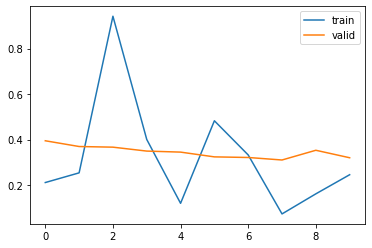

In [32]:
plt.plot(t_loss_his, label="train")
plt.plot(v_loss_his, label="valid")
plt.legend()
plt.show()

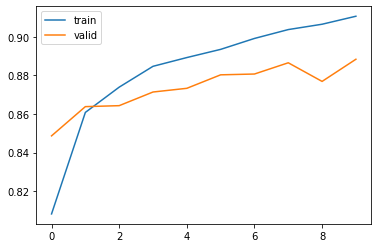

In [33]:
plt.plot(t_acc_his, label="train")
plt.plot(v_acc_his, label="valid")
plt.legend()
plt.show()

In [34]:
v_loss, v_acc = evaluate(model, test_loader)
print("Test Loss : {:.4f}\t accuracy: {:.2f}%\n".format(v_loss, v_acc*100.))

  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss : 0.3141	 accuracy: 88.88%



### CNN

In [35]:
USE_CUDA = torch.cuda.is_available()
DEVICE = "cuda" if USE_CUDA else "cpu"

model = CNN().to(DEVICE)
opt = optim.Adam(model.parameters())

print("Device :", DEVICE)
summary_(model,(1,28,28), device=DEVICE)

Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
         MaxPool2d-2            [-1, 8, 14, 14]               0
         LeakyReLU-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           1,168
         MaxPool2d-5             [-1, 16, 7, 7]               0
         LeakyReLU-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 32, 7, 7]           4,640
         MaxPool2d-8             [-1, 32, 3, 3]               0
         LeakyReLU-9             [-1, 32, 3, 3]               0
           Conv2d-10             [-1, 64, 3, 3]          18,496
        MaxPool2d-11             [-1, 64, 1, 1]               0
        LeakyReLU-12             [-1, 64, 1, 1]               0
AdaptiveAvgPool2d-13             [-1, 64, 1, 1]               0
           Linear-14     

In [36]:
# 학습 시작 #
t_loss_his, t_acc_his, v_loss_his, v_acc_his = train(EPOCHS = 10, model = model, train_loader = train_loader, opt = opt)

<<< EPOCH 1 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 1.139337	 Acc : 0.024
Training : [6400/48000 (13%)]	Loss: 0.699056	 Acc : 0.067
Training : [9600/48000 (20%)]	Loss: 0.882671	 Acc : 0.112
Training : [12800/48000 (27%)]	Loss: 0.611760	 Acc : 0.159
Training : [16000/48000 (33%)]	Loss: 0.582137	 Acc : 0.208
Training : [19200/48000 (40%)]	Loss: 0.829867	 Acc : 0.258
Training : [22400/48000 (47%)]	Loss: 0.819843	 Acc : 0.307
Training : [25600/48000 (53%)]	Loss: 0.482544	 Acc : 0.358
Training : [28800/48000 (60%)]	Loss: 0.599150	 Acc : 0.409
Training : [32000/48000 (67%)]	Loss: 0.708488	 Acc : 0.461
Training : [35200/48000 (73%)]	Loss: 0.383371	 Acc : 0.513
Training : [38400/48000 (80%)]	Loss: 0.583299	 Acc : 0.565
Training : [41600/48000 (87%)]	Loss: 0.266986	 Acc : 0.619
Training : [44800/48000 (93%)]	Loss: 0.460232	 Acc : 0.673


  0%|          | 0/375 [00:00<?, ?it/s]

[1] valid Loss : 0.5410	 accuracy: 79.25%


<<< EPOCH 2 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.342676	 Acc : 0.055
Training : [6400/48000 (13%)]	Loss: 0.558900	 Acc : 0.109
Training : [9600/48000 (20%)]	Loss: 0.310044	 Acc : 0.164
Training : [12800/48000 (27%)]	Loss: 0.346726	 Acc : 0.219
Training : [16000/48000 (33%)]	Loss: 0.221389	 Acc : 0.275
Training : [19200/48000 (40%)]	Loss: 0.415124	 Acc : 0.330
Training : [22400/48000 (47%)]	Loss: 0.493865	 Acc : 0.386
Training : [25600/48000 (53%)]	Loss: 0.361956	 Acc : 0.442
Training : [28800/48000 (60%)]	Loss: 0.448647	 Acc : 0.499
Training : [32000/48000 (67%)]	Loss: 0.349379	 Acc : 0.555
Training : [35200/48000 (73%)]	Loss: 0.293650	 Acc : 0.611
Training : [38400/48000 (80%)]	Loss: 0.396654	 Acc : 0.668
Training : [41600/48000 (87%)]	Loss: 0.469888	 Acc : 0.725
Training : [44800/48000 (93%)]	Loss: 0.312424	 Acc : 0.781


  0%|          | 0/375 [00:00<?, ?it/s]

[2] valid Loss : 0.3919	 accuracy: 85.61%


<<< EPOCH 3 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.290936	 Acc : 0.058
Training : [6400/48000 (13%)]	Loss: 0.473958	 Acc : 0.116
Training : [9600/48000 (20%)]	Loss: 0.636889	 Acc : 0.173
Training : [12800/48000 (27%)]	Loss: 0.397979	 Acc : 0.230
Training : [16000/48000 (33%)]	Loss: 0.363886	 Acc : 0.287
Training : [19200/48000 (40%)]	Loss: 0.284932	 Acc : 0.344
Training : [22400/48000 (47%)]	Loss: 0.266606	 Acc : 0.401
Training : [25600/48000 (53%)]	Loss: 0.213360	 Acc : 0.459
Training : [28800/48000 (60%)]	Loss: 0.332665	 Acc : 0.516
Training : [32000/48000 (67%)]	Loss: 0.298404	 Acc : 0.573
Training : [35200/48000 (73%)]	Loss: 0.348087	 Acc : 0.631
Training : [38400/48000 (80%)]	Loss: 0.290906	 Acc : 0.688
Training : [41600/48000 (87%)]	Loss: 0.312785	 Acc : 0.745
Training : [44800/48000 (93%)]	Loss: 0.198446	 Acc : 0.803


  0%|          | 0/375 [00:00<?, ?it/s]

[3] valid Loss : 0.3655	 accuracy: 86.33%


<<< EPOCH 4 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.656520	 Acc : 0.059
Training : [6400/48000 (13%)]	Loss: 0.380046	 Acc : 0.116
Training : [9600/48000 (20%)]	Loss: 0.313513	 Acc : 0.175
Training : [12800/48000 (27%)]	Loss: 0.432390	 Acc : 0.232
Training : [16000/48000 (33%)]	Loss: 0.320859	 Acc : 0.291
Training : [19200/48000 (40%)]	Loss: 0.404882	 Acc : 0.349
Training : [22400/48000 (47%)]	Loss: 0.330815	 Acc : 0.407
Training : [25600/48000 (53%)]	Loss: 0.247529	 Acc : 0.465
Training : [28800/48000 (60%)]	Loss: 0.358538	 Acc : 0.523
Training : [32000/48000 (67%)]	Loss: 0.174734	 Acc : 0.581
Training : [35200/48000 (73%)]	Loss: 0.391973	 Acc : 0.640
Training : [38400/48000 (80%)]	Loss: 0.339194	 Acc : 0.699
Training : [41600/48000 (87%)]	Loss: 0.201115	 Acc : 0.757
Training : [44800/48000 (93%)]	Loss: 0.617594	 Acc : 0.816


  0%|          | 0/375 [00:00<?, ?it/s]

[4] valid Loss : 0.3604	 accuracy: 86.79%


<<< EPOCH 5 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.303398	 Acc : 0.060
Training : [6400/48000 (13%)]	Loss: 0.539834	 Acc : 0.119
Training : [9600/48000 (20%)]	Loss: 0.611136	 Acc : 0.178
Training : [12800/48000 (27%)]	Loss: 0.461850	 Acc : 0.236
Training : [16000/48000 (33%)]	Loss: 0.272697	 Acc : 0.295
Training : [19200/48000 (40%)]	Loss: 0.324083	 Acc : 0.354
Training : [22400/48000 (47%)]	Loss: 0.119044	 Acc : 0.413
Training : [25600/48000 (53%)]	Loss: 0.290538	 Acc : 0.472
Training : [28800/48000 (60%)]	Loss: 0.244530	 Acc : 0.531
Training : [32000/48000 (67%)]	Loss: 0.226217	 Acc : 0.589
Training : [35200/48000 (73%)]	Loss: 0.281956	 Acc : 0.648
Training : [38400/48000 (80%)]	Loss: 0.396937	 Acc : 0.707
Training : [41600/48000 (87%)]	Loss: 0.414904	 Acc : 0.766
Training : [44800/48000 (93%)]	Loss: 0.213005	 Acc : 0.825


  0%|          | 0/375 [00:00<?, ?it/s]

[5] valid Loss : 0.3243	 accuracy: 87.98%


<<< EPOCH 6 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.107351	 Acc : 0.060
Training : [6400/48000 (13%)]	Loss: 0.238162	 Acc : 0.119
Training : [9600/48000 (20%)]	Loss: 0.204964	 Acc : 0.178
Training : [12800/48000 (27%)]	Loss: 0.206083	 Acc : 0.237
Training : [16000/48000 (33%)]	Loss: 0.461112	 Acc : 0.297
Training : [19200/48000 (40%)]	Loss: 0.575618	 Acc : 0.355
Training : [22400/48000 (47%)]	Loss: 0.237697	 Acc : 0.415
Training : [25600/48000 (53%)]	Loss: 0.216556	 Acc : 0.474
Training : [28800/48000 (60%)]	Loss: 0.291472	 Acc : 0.533
Training : [32000/48000 (67%)]	Loss: 0.358585	 Acc : 0.592
Training : [35200/48000 (73%)]	Loss: 0.251310	 Acc : 0.651
Training : [38400/48000 (80%)]	Loss: 0.135977	 Acc : 0.711
Training : [41600/48000 (87%)]	Loss: 0.439335	 Acc : 0.770
Training : [44800/48000 (93%)]	Loss: 0.362051	 Acc : 0.829


  0%|          | 0/375 [00:00<?, ?it/s]

[6] valid Loss : 0.3448	 accuracy: 87.84%


<<< EPOCH 7 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.090148	 Acc : 0.060
Training : [6400/48000 (13%)]	Loss: 0.219324	 Acc : 0.120
Training : [9600/48000 (20%)]	Loss: 0.232219	 Acc : 0.180
Training : [12800/48000 (27%)]	Loss: 0.175259	 Acc : 0.240
Training : [16000/48000 (33%)]	Loss: 0.396096	 Acc : 0.300
Training : [19200/48000 (40%)]	Loss: 0.209739	 Acc : 0.359
Training : [22400/48000 (47%)]	Loss: 0.276469	 Acc : 0.418
Training : [25600/48000 (53%)]	Loss: 0.152734	 Acc : 0.478
Training : [28800/48000 (60%)]	Loss: 0.520134	 Acc : 0.538
Training : [32000/48000 (67%)]	Loss: 0.406465	 Acc : 0.597
Training : [35200/48000 (73%)]	Loss: 0.148253	 Acc : 0.657
Training : [38400/48000 (80%)]	Loss: 0.389092	 Acc : 0.716
Training : [41600/48000 (87%)]	Loss: 0.284409	 Acc : 0.775
Training : [44800/48000 (93%)]	Loss: 0.227030	 Acc : 0.834


  0%|          | 0/375 [00:00<?, ?it/s]

[7] valid Loss : 0.3175	 accuracy: 88.30%


<<< EPOCH 8 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.179836	 Acc : 0.060
Training : [6400/48000 (13%)]	Loss: 0.333029	 Acc : 0.120
Training : [9600/48000 (20%)]	Loss: 0.420319	 Acc : 0.180
Training : [12800/48000 (27%)]	Loss: 0.345926	 Acc : 0.239
Training : [16000/48000 (33%)]	Loss: 0.516230	 Acc : 0.299
Training : [19200/48000 (40%)]	Loss: 0.321958	 Acc : 0.359
Training : [22400/48000 (47%)]	Loss: 0.471851	 Acc : 0.419
Training : [25600/48000 (53%)]	Loss: 0.242339	 Acc : 0.479
Training : [28800/48000 (60%)]	Loss: 0.140956	 Acc : 0.538
Training : [32000/48000 (67%)]	Loss: 0.177980	 Acc : 0.599
Training : [35200/48000 (73%)]	Loss: 0.249231	 Acc : 0.659
Training : [38400/48000 (80%)]	Loss: 0.268834	 Acc : 0.719
Training : [41600/48000 (87%)]	Loss: 0.221771	 Acc : 0.778
Training : [44800/48000 (93%)]	Loss: 0.229986	 Acc : 0.837


  0%|          | 0/375 [00:00<?, ?it/s]

[8] valid Loss : 0.3067	 accuracy: 89.06%


<<< EPOCH 9 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.225590	 Acc : 0.061
Training : [6400/48000 (13%)]	Loss: 0.392612	 Acc : 0.121
Training : [9600/48000 (20%)]	Loss: 0.226053	 Acc : 0.182
Training : [12800/48000 (27%)]	Loss: 0.237181	 Acc : 0.242
Training : [16000/48000 (33%)]	Loss: 0.444444	 Acc : 0.302
Training : [19200/48000 (40%)]	Loss: 0.230686	 Acc : 0.362
Training : [22400/48000 (47%)]	Loss: 0.036054	 Acc : 0.423
Training : [25600/48000 (53%)]	Loss: 0.410710	 Acc : 0.483
Training : [28800/48000 (60%)]	Loss: 0.154327	 Acc : 0.544
Training : [32000/48000 (67%)]	Loss: 0.187334	 Acc : 0.604
Training : [35200/48000 (73%)]	Loss: 0.164887	 Acc : 0.665
Training : [38400/48000 (80%)]	Loss: 0.161008	 Acc : 0.724
Training : [41600/48000 (87%)]	Loss: 0.235110	 Acc : 0.785
Training : [44800/48000 (93%)]	Loss: 0.243901	 Acc : 0.844


  0%|          | 0/375 [00:00<?, ?it/s]

[9] valid Loss : 0.3195	 accuracy: 88.60%


<<< EPOCH 10 >>>


  0%|          | 0/1500 [00:00<?, ?it/s]

Training : [3200/48000 (7%)]	Loss: 0.082751	 Acc : 0.061
Training : [6400/48000 (13%)]	Loss: 0.141873	 Acc : 0.121
Training : [9600/48000 (20%)]	Loss: 0.196526	 Acc : 0.182
Training : [12800/48000 (27%)]	Loss: 0.319001	 Acc : 0.243
Training : [16000/48000 (33%)]	Loss: 0.116227	 Acc : 0.304
Training : [19200/48000 (40%)]	Loss: 0.217069	 Acc : 0.364
Training : [22400/48000 (47%)]	Loss: 0.255308	 Acc : 0.425
Training : [25600/48000 (53%)]	Loss: 0.192816	 Acc : 0.485
Training : [28800/48000 (60%)]	Loss: 0.200121	 Acc : 0.545
Training : [32000/48000 (67%)]	Loss: 0.373789	 Acc : 0.606
Training : [35200/48000 (73%)]	Loss: 0.265773	 Acc : 0.666
Training : [38400/48000 (80%)]	Loss: 0.250911	 Acc : 0.726
Training : [41600/48000 (87%)]	Loss: 0.254964	 Acc : 0.786
Training : [44800/48000 (93%)]	Loss: 0.157439	 Acc : 0.847


  0%|          | 0/375 [00:00<?, ?it/s]

[10] valid Loss : 0.2796	 accuracy: 89.85%




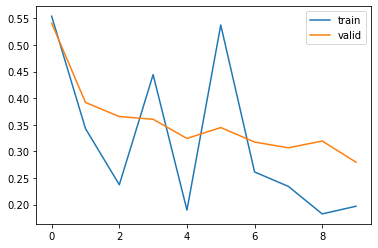

In [37]:
plt.plot(t_loss_his, label="train")
plt.plot(v_loss_his, label="valid")
plt.legend()
plt.show()

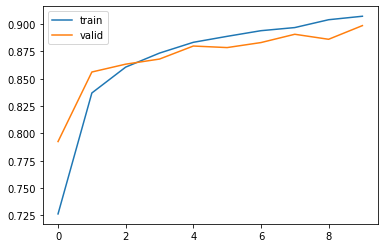

In [38]:
plt.plot(t_acc_his, label="train")
plt.plot(v_acc_his, label="valid")
plt.legend()
plt.show()

In [39]:
v_loss, v_acc = evaluate(model, test_loader)
print("Test Loss : {:.4f}\t accuracy: {:.2f}%\n".format(v_loss, v_acc*100.))

  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss : 0.2746	 accuracy: 89.97%

